<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/17.1.25.stepan_colab_HCPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Social Science: PCA and Cluster Analysis of the Literature

#Setup

In [ ]:
!pip install scikit-learn-extra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive') # this asks for your google account
# load data from our private google folder shared among us
data = pd.read_excel("/content/drive/MyDrive/QSS_Colab/keyword_data.xlsx")
metadata = pd.read_excel("/content/drive/MyDrive/QSS_Colab/metadata.xlsx")

Mounted at /content/drive


#Data cleaning

In [3]:
# Rename "Broekaert_2018" in metadata
metadata.loc[252, 'file_name'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
data.loc[252, 'filename'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
# Delete duplicit paper "Yukalov et al. - 2018 - Information processing by networks of quantum deci.pdf"
data = data.drop(1170)
# Delete paper "Yilmaz - 2017 - Quantum cognition models of ethical decision-makin.pdf" that is only present in data
data = data.drop(1166)
# Delete paper "Park_2016_Decision-making &amp quantum mechanical models of cognitive processing.pdf" that is only present in metadata
metadata = metadata.drop(892)

# Keywords

In [4]:
# Exclude authors and create df
df = data.drop(columns=[data.columns[i] for i in [1,2,4,16,30]])
# Exclude social science fields
df = df.drop(columns=df.columns[26:38])
# Possibly also Exclude "quantum" and "quantization"
df = df.drop(columns=df.columns[17:19])

# keep only papers with some non-zero values in the final columns we want to keep
df = df[df.iloc[:, 2:24].sum(axis=1) > 0]
df = df.reset_index(drop=True)

In [ ]:
[(i, list(df.keys())[i]) for i in range(len(df.keys()))]

In [5]:
df

,filename,born's rule,collapse,commutativity,complementarity,contextuality,eigenvalue,eigenvector,entanglement,exclusion principle,...,observer effect,operator,probability amplitude,dinger equation,superposition,tunneling,uncertainty,uncertainty principle,wave function,wave-particle duality
0,2018_Quantum Models of Cognition and Decision.pdf,0,0,3,3,0,15,12,2,0,...,0,104,0,3,4,0,10,2,0,0
1,Abel_2023_The quantum foundations of utility a...,0,5,0,0,0,9,0,1,0,...,0,35,1,4,2,0,6,2,2,0
2,Acacio de Barros_Oas_2015_Some examples of con...,0,4,0,0,77,1,0,10,0,...,0,6,0,0,4,0,2,0,5,0
3,Acacio de Barros_Oas_2018_Mapping Quantum Real...,0,0,0,0,39,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
4,Acacio De Barros_Suppes_2009_Quantum mechanics...,0,6,2,1,20,1,4,0,0,...,0,3,0,0,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,Zhou et al_2022_Nonlinear dynamics of a hetero...,0,0,0,0,0,2,0,29,0,...,0,3,0,0,0,0,0,0,0,0
1156,Zhou et al_2023_The dynamics of a quantum Cour...,0,0,0,0,0,3,0,35,0,...,0,2,0,0,0,0,0,0,0,0
1157,Zohar_2022_Zero Distance.pdf,0,9,0,0,3,0,0,4,0,...,0,0,0,0,5,0,39,8,19,0
1158,Zorn_Smith_2011_Pseudo-classical Nonseparabili...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
# Or keeep only the authors
#df = data[data.columns[[1,2,4,16,30]]]

# Numbering the data for centroid extraction

In [6]:
metadata = metadata.reset_index()
metadata = metadata.rename(columns={'index': 'id'})
metadata['id'] = metadata['id'] + 1

df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df['id'] = df['id'] + 1

# Scaling in the rows

In [32]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns


features = features.div(features.sum(axis=1), axis=0) # row normalization as Michael suggested, dividing the values by the sum of their row (paper)
#features = StandardScaler().fit_transform(features.T).T # Z-score standardization on transposed data to work in rows

features = pd.DataFrame(features, columns=feature_names)
features

,born's rule,collapse,commutativity,complementarity,contextuality,eigenvalue,eigenvector,entanglement,exclusion principle,hamiltonian,...,observer effect,operator,probability amplitude,dinger equation,superposition,tunneling,uncertainty,uncertainty principle,wave function,wave-particle duality
0,0.0,0.000000,0.014218,0.014218,0.000000,0.071090,0.056872,0.009479,0.0,0.023697,...,0.0,0.492891,0.000000,0.014218,0.018957,0.0,0.047393,0.009479,0.000000,0.0
1,0.0,0.046729,0.000000,0.000000,0.000000,0.084112,0.000000,0.009346,0.0,0.336449,...,0.0,0.327103,0.009346,0.037383,0.018692,0.0,0.056075,0.018692,0.018692,0.0
2,0.0,0.028571,0.000000,0.000000,0.550000,0.007143,0.000000,0.071429,0.0,0.007143,...,0.0,0.042857,0.000000,0.000000,0.028571,0.0,0.014286,0.000000,0.035714,0.0
3,0.0,0.000000,0.000000,0.000000,0.829787,0.000000,0.000000,0.021277,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.063830,0.000000,0.000000,0.0
4,0.0,0.073171,0.024390,0.012195,0.243902,0.012195,0.048780,0.000000,0.0,0.036585,...,0.0,0.036585,0.000000,0.000000,0.073171,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0.0,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.852941,0.0,0.000000,...,0.0,0.088235,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1156,0.0,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.875000,0.0,0.000000,...,0.0,0.050000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1157,0.0,0.097826,0.000000,0.000000,0.032609,0.000000,0.000000,0.043478,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.054348,0.0,0.423913,0.086957,0.206522,0.0
1158,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.400000,0.0,0.000000,0.000000,0.000000,0.0


# Scaling in the columns

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns

# scale with either z-score standardization or MinMax normalization
# features = StandardScaler().fit_transform(features) #Z-score
# features = MinMaxScaler().fit_transform(features) # MinMax

#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 0).astype(int) # binary >0
#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 4).astype(int) # binary >4

features = pd.DataFrame(features, columns=feature_names)
features

# Data analysis

#PCA

Explained variance ratio: [0.21805248 0.17690307 0.12289477 0.1014373  0.07854515 0.06598143
 0.05947673 0.04551538 0.04025369 0.03393288]


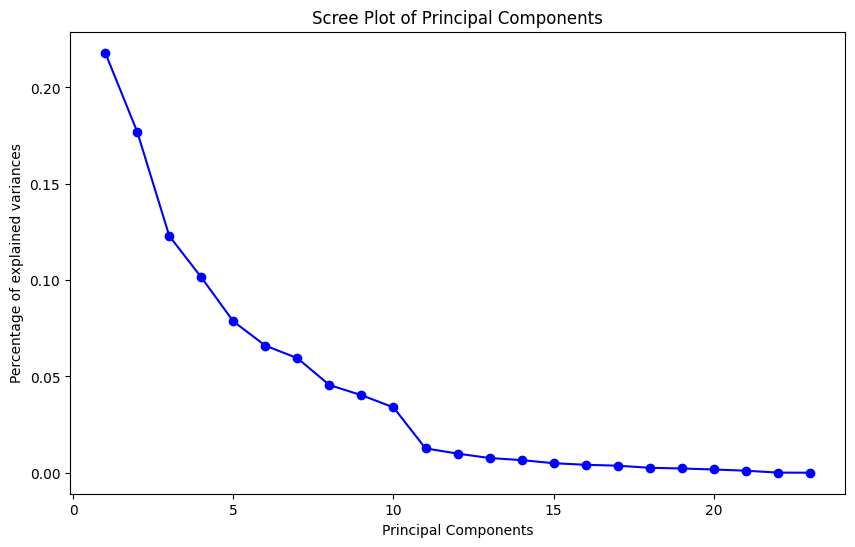

                         feature    PC   loading
entanglement        entanglement   PC1  0.825192
operator                operator   PC1 -0.536061
uncertainty          uncertainty   PC1 -0.092500
hamiltonian          hamiltonian   PC1 -0.080572
interference        interference   PC1 -0.074973
...                          ...   ...       ...
born's rule          born's rule  PC23  0.208514
complementarity  complementarity  PC23  0.208514
superposition      superposition  PC23  0.208514
wave function      wave function  PC23  0.208514
operator                operator  PC23  0.208514

[115 rows x 3 columns]
                     feature   PC   loading
entanglement    entanglement  PC1  0.825192
interference    interference  PC1 -0.074973
hamiltonian      hamiltonian  PC1 -0.080572
uncertainty      uncertainty  PC1 -0.092500
operator            operator  PC1 -0.536061
operator            operator  PC2  0.693404
entanglement    entanglement  PC2  0.384714
superposition  superposition  PC2 -0

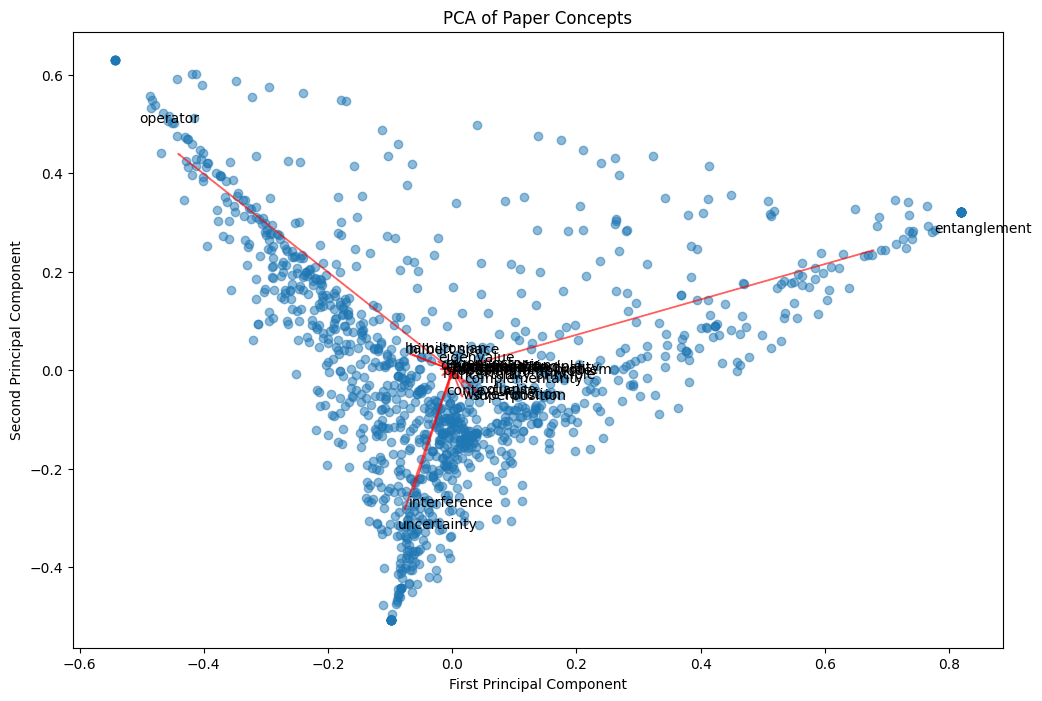

,feature,PC,loading
entanglement,entanglement,PC1,0.825192
interference,interference,PC1,-0.074973
hamiltonian,hamiltonian,PC1,-0.080572
uncertainty,uncertainty,PC1,-0.092500
operator,operator,PC1,-0.536061
operator,operator,PC2,0.693404
entanglement,entanglement,PC2,0.384714
superposition,superposition,PC2,-0.081865
interference,interference,PC2,-0.380147
uncertainty,uncertainty,PC2,-0.444301


In [33]:
pca = PCA()
pca_result = pca.fit_transform(features)
print("Explained variance ratio:", pca.explained_variance_ratio_[:10])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# Top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })

    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])

print(top_loadings)

# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2', 'PC3', 'PC4'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()
display(pc12_loadings)

How many PCs do we want? Literature says probably a sum between 80-90% of explained variance

Number of components needed to explain 80% of variance: 7


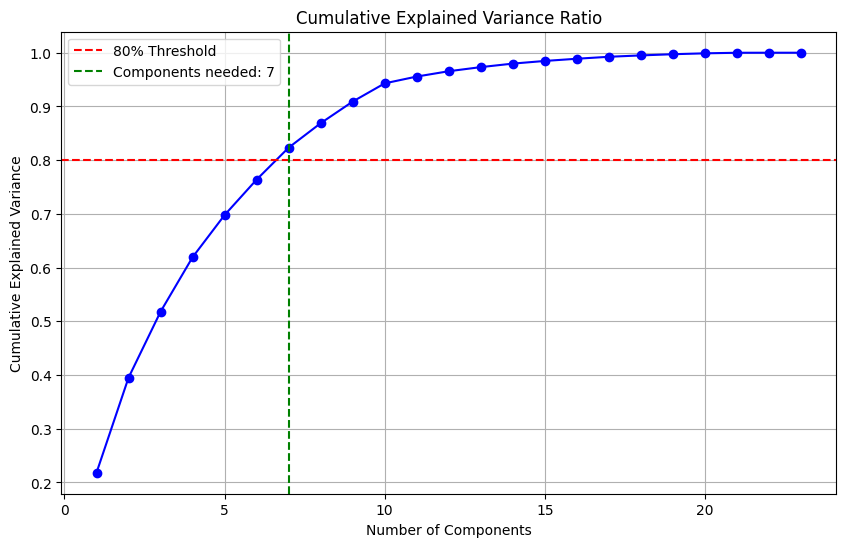


Cumulative explained variance for first 10 components:
Components 1-1: 0.218
Components 1-2: 0.395
Components 1-3: 0.518
Components 1-4: 0.619
Components 1-5: 0.698
Components 1-6: 0.764
Components 1-7: 0.823
Components 1-8: 0.869
Components 1-9: 0.909
Components 1-10: 0.943


In [9]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# Find number of components needed for 80% variance (we can change this)
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1),
         cumulative_variance_ratio,
         'bo-')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axvline(x=n_components_80, color='g', linestyle='--',
            label=f'Components needed: {n_components_80}')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

print("\nCumulative explained variance for first 10 components:")
for i in range(10):
    print(f"Components 1-{i+1}: {cumulative_variance_ratio[i]:.3f}")

# Hierarchical Clustering on Principal Components (HCPC)

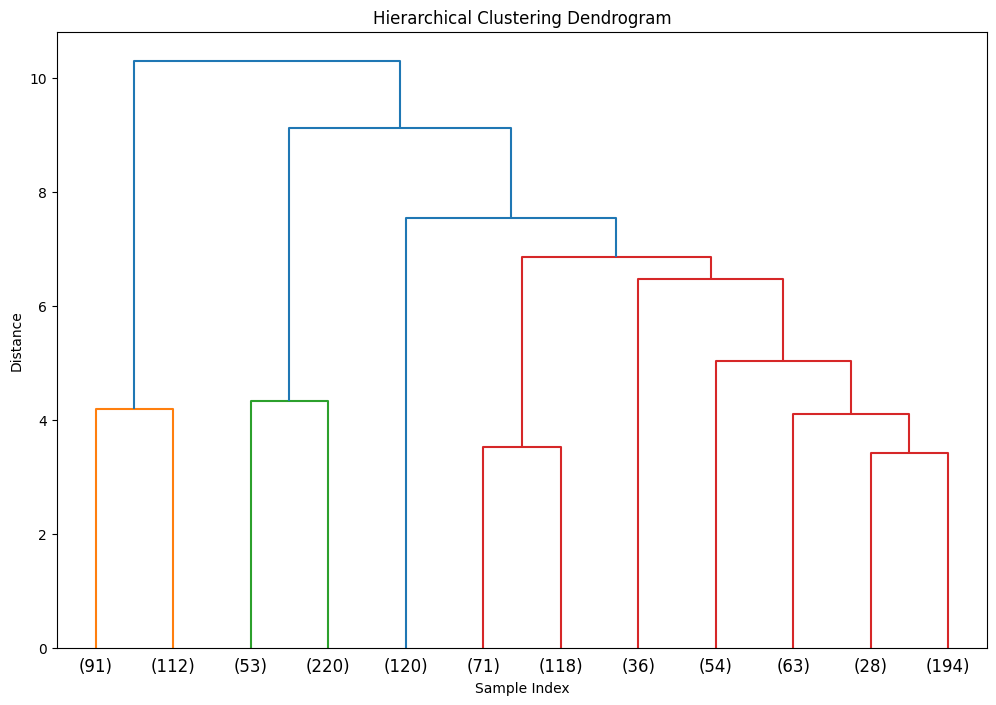

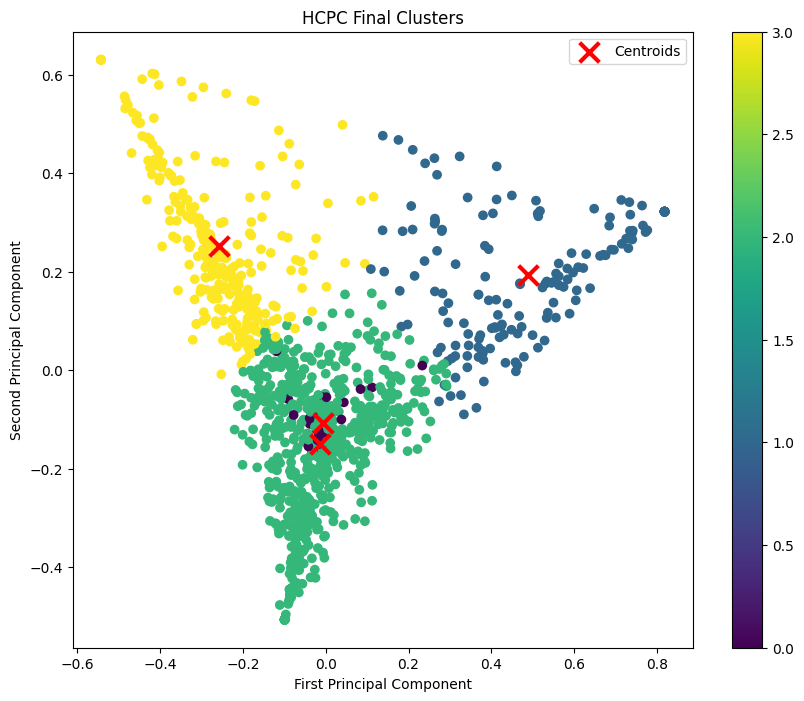

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1. Define how many PCs to use
n_components = 8 # I think we should use between 7 and 9 based on the PCA
selected_components = pca_result[:, :n_components]

# 2. Hierarchical clustering uisng Ward
linked = linkage(selected_components, method='ward') # the methods can be different. Ward method is the one we use in Ipsos and seemingly the typical choice in the literature

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# 3. Get initial clusters from hierarchical clustering # optional step though, we dont really need them
n_clusters = 4
hc_labels = fcluster(linked, n_clusters, criterion='maxclust')

# 4. K-means to finalize things
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(selected_components)
final_labels = kmeans.labels_


# Visualize final clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=final_labels, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.colorbar(scatter)
plt.title('HCPC Final Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

K-Medoids as an alternative ending

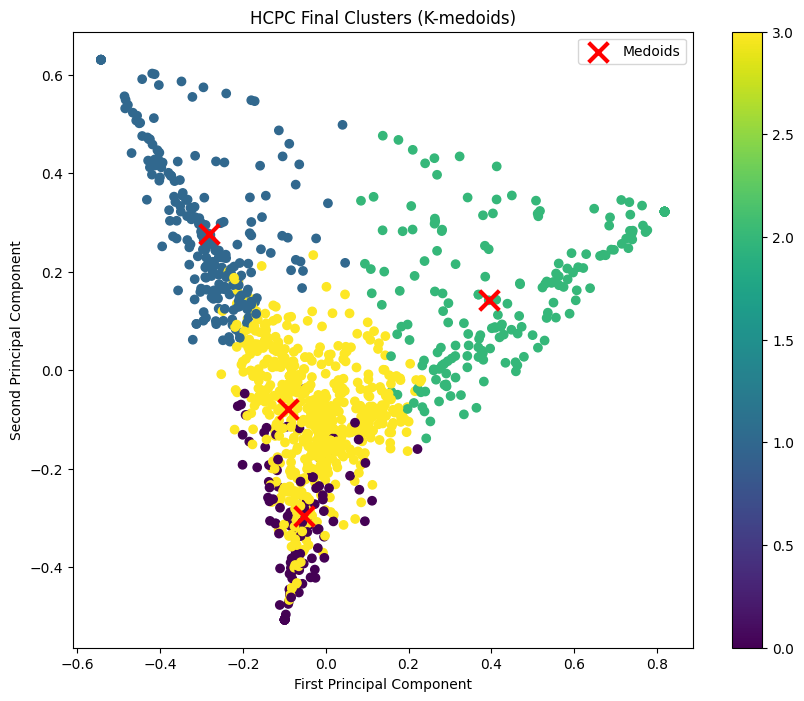

In [14]:
kmedoids = KMedoids(n_clusters=n_clusters,
                    random_state=42,
                    metric='euclidean')
kmedoids.fit(selected_components)
final_labels = kmedoids.labels_

# Visualize final clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=final_labels, cmap='viridis')

# Get medoid locations in PCA space
medoid_indices = kmedoids.medoid_indices_
medoid_locations = pca_result[medoid_indices]

# Plot medoids
plt.scatter(medoid_locations[:, 0], medoid_locations[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')

plt.colorbar(scatter)
plt.title('HCPC Final Clusters (K-medoids)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

# Get central papers from the HCPC

Kmeans

In [16]:
centroids_list = []
for i in range(n_clusters):
    distances = np.sum((selected_components - kmeans.cluster_centers_[i])**2, axis=1)
    top_indices = np.argsort(distances)[:10] # N of central papers
    pca_coords = pca_result[top_indices]

    feature_importance = np.dot(pca_coords[:, :8], pca.components_[:8, :])
    feature_importance_df = pd.DataFrame(
        feature_importance,
        columns=features.columns
    )

    # Get top 5 most important features for each paper
    top_features = pd.DataFrame({
        'paper_id': df['id'].iloc[top_indices].values,
        'top_features': [
            ', '.join(feature_importance_df.iloc[j].nlargest(5).index.tolist())
            for j in range(len(feature_importance_df))
        ]
    })
        # Get PCA coordinates for the top papers, here we work with the 8 PCs, we can change it
    cluster_papers = pd.DataFrame({
        'cluster': [i + 1] * 10,
        'rank': range(1, 11),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices],
        'PC1': pca_coords[:, 0],
        'PC2': pca_coords[:, 1],
        'PC3': pca_coords[:, 2],
        'PC4': pca_coords[:, 3],
        'PC5': pca_coords[:, 4],
        'PC6': pca_coords[:, 5],
        'PC7': pca_coords[:, 6],
        'PC8': pca_coords[:, 7],
        'key_features': top_features['top_features']
    })
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)
centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('means_center_papers_hcpc.csv', index=False)

KMedoids

In [19]:
centroids_list = []
for i in range(n_clusters):
    medoid_point = selected_components[kmedoids.medoid_indices_[i]]
    distances = np.sum((selected_components - medoid_point)**2, axis=1)
    top_indices = np.argsort(distances)[:10]  # N of central papers
    pca_coords = pca_result[top_indices]

    feature_importance = np.dot(pca_coords[:, :8], pca.components_[:8, :])
    feature_importance_df = pd.DataFrame(
        feature_importance,
        columns=features.columns
    )

    # Get top 5 most important features for each paper
    top_features = pd.DataFrame({
        'paper_id': df['id'].iloc[top_indices].values,
        'top_features': [
            ', '.join(feature_importance_df.iloc[j].nlargest(5).index.tolist())
            for j in range(len(feature_importance_df))
        ]
    })
     # Get PCA coordinates for the top papers, here we work with the 8 PCs, we can change it
    cluster_papers = pd.DataFrame({
        'cluster': [i + 1] * 10,
        'rank': range(1, 11),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices],
        'PC1': pca_coords[:, 0],
        'PC2': pca_coords[:, 1],
        'PC3': pca_coords[:, 2],
        'PC4': pca_coords[:, 3],
        'PC5': pca_coords[:, 4],
        'PC6': pca_coords[:, 5],
        'PC7': pca_coords[:, 6],
        'PC8': pca_coords[:, 7],
        'key_features': top_features['top_features']
    })
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)
centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('medoids_center_papers_hcpc.csv', index=False)

In [20]:
clustered_df = df.copy()
clustered_df['cluster'] = final_labels + 1

clustered_df.to_csv('papers_with_clusters.csv', index=False)

# K-Means vs K-Medoids

Adjusted Rand Index: 0.535
Adjusted Mutual Information: 0.610
Normalized Mutual Information: 0.612

Confusion Matrix (normalized by row):
col_0         0         1         2         3
row_0                                        
0      0.000000  0.000000  0.027778  0.972222
1      0.000000  0.000000  1.000000  0.000000
2      0.172619  0.000000  0.038690  0.788690
3      0.000000  0.781690  0.010563  0.207746
All    0.100000  0.191379  0.170690  0.537931


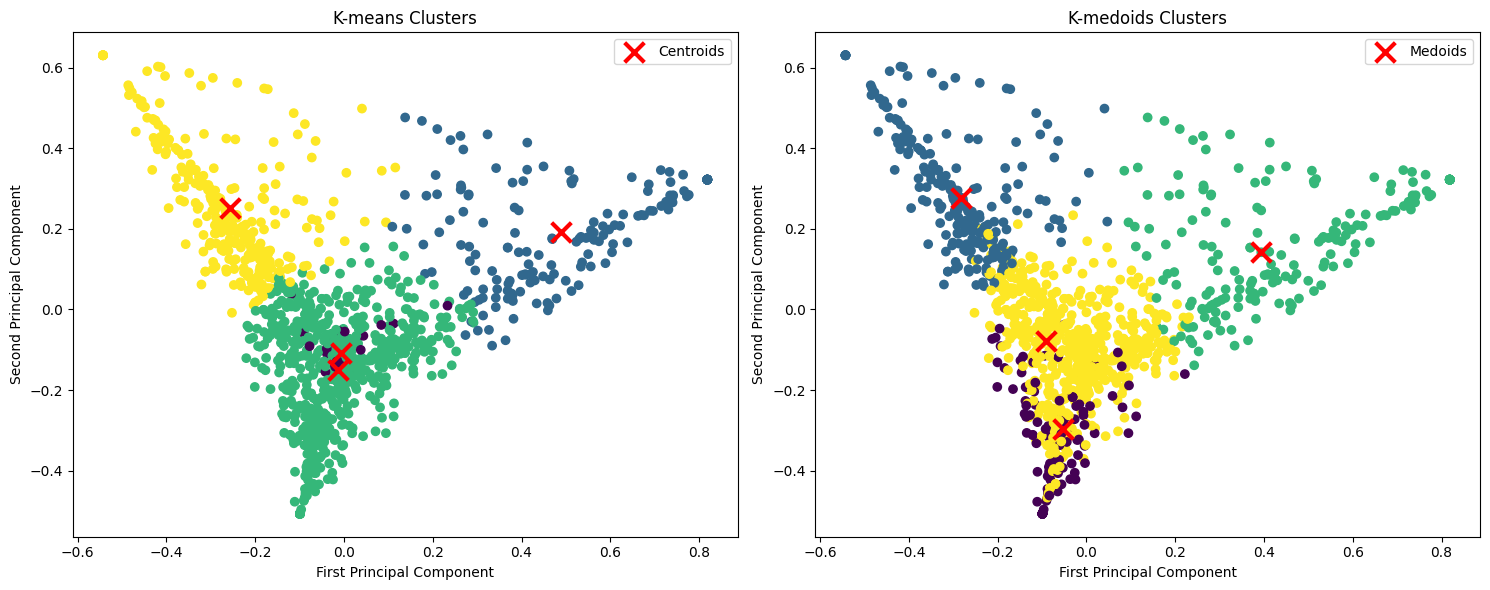

In [17]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
kmeans_labels = kmeans.labels_
kmedoids_labels = kmedoids.labels_

# similarity metrics
ari = adjusted_rand_score(kmeans_labels, kmedoids_labels)
ami = adjusted_mutual_info_score(kmeans_labels, kmedoids_labels)
nmi = normalized_mutual_info_score(kmeans_labels, kmedoids_labels)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Adjusted Mutual Information: {ami:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

confusion_matrix = pd.crosstab(
    kmeans_labels,
    kmedoids_labels,
    margins=True,
    normalize='index'
)
print("\nConfusion Matrix (normalized by row):")
print(confusion_matrix)

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K-means plot
scatter1 = ax1.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax1.set_title('K-means Clusters')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend()

# K-medoids plot
scatter2 = ax2.scatter(pca_result[:, 0], pca_result[:, 1], c=kmedoids_labels, cmap='viridis')
ax2.scatter(medoid_locations[:, 0], medoid_locations[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')
ax2.set_title('K-medoids Clusters')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.legend()

plt.tight_layout()
plt.show()

# Somewhat good overlap of K-Means and K-Medoids with 7 PCs and 4 clusters. ARI=0.577; C1 (95.2%), C2 (94.4%), C3 (98.8%), C4 (38%) and (61.4%)

# Very good overlap of K-Means and K-Medoids with 9 PCs and 4 clusters. ARI=0.77; C1 (80.4% overlap), C2(88.5% overlap), C3 (95.6% overlap), C4 (100% overlap)

# Random Forest for a ML approach to "predicting" the clusters we got from the PCA a Cluster Analysis with the just the original (normalized) keywords.



Gives us the same picture as the PCA = Operator, Uncertainty, and Entanglement predict one cluster each, the fourth is predicted by a mix of words. Not sure we get any useful info here. **But the model fits extremely well all clusters from the original data, this is good robustness for the pca and clsuter approach we have.**

Top 20 most important features:
                  feature  importance
14               operator    0.287185
7            entanglement    0.279269
19            uncertainty    0.172526
11           interference    0.044247
17          superposition    0.037166
10          hilbert space    0.029894
1                collapse    0.026751
21          wave function    0.017555
9             hamiltonian    0.016671
4           contextuality    0.015217
5              eigenvalue    0.014718
20  uncertainty principle    0.013593
3         complementarity    0.009948
16        dinger equation    0.008648
15  probability amplitude    0.007651
6             eigenvector    0.005128
2           commutativity    0.004962
12    measurement problem    0.003444
18              tunneling    0.001810
22  wave-particle duality    0.001664

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.87      0.89        23
           2       1.00      0.94    

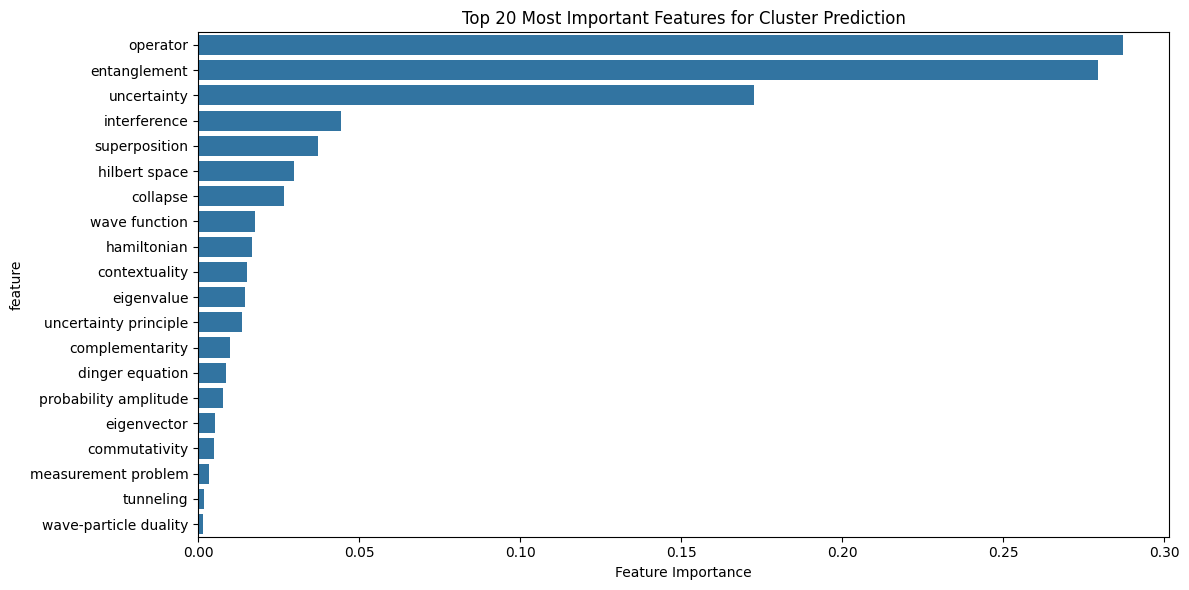

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = features
y = final_labels + 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)


feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# 20 most important features
print("Top 20 most important features:")
print(feature_importance.head(20))

# Model performance
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# viz
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features for Cluster Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


=== ANALYSIS FOR CLUSTER 1 ===

Top 10 most important features for Cluster 1:
                  feature  importance
19            uncertainty    0.698405
20  uncertainty principle    0.057077
14               operator    0.043600
7            entanglement    0.039896
11           interference    0.024141
17          superposition    0.023557
10          hilbert space    0.020486
1                collapse    0.017010
21          wave function    0.011679
4           contextuality    0.010781

Classification Report for Cluster 1:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       209
           1       0.91      0.91      0.91        23

    accuracy                           0.98       232
   macro avg       0.95      0.95      0.95       232
weighted avg       0.98      0.98      0.98       232



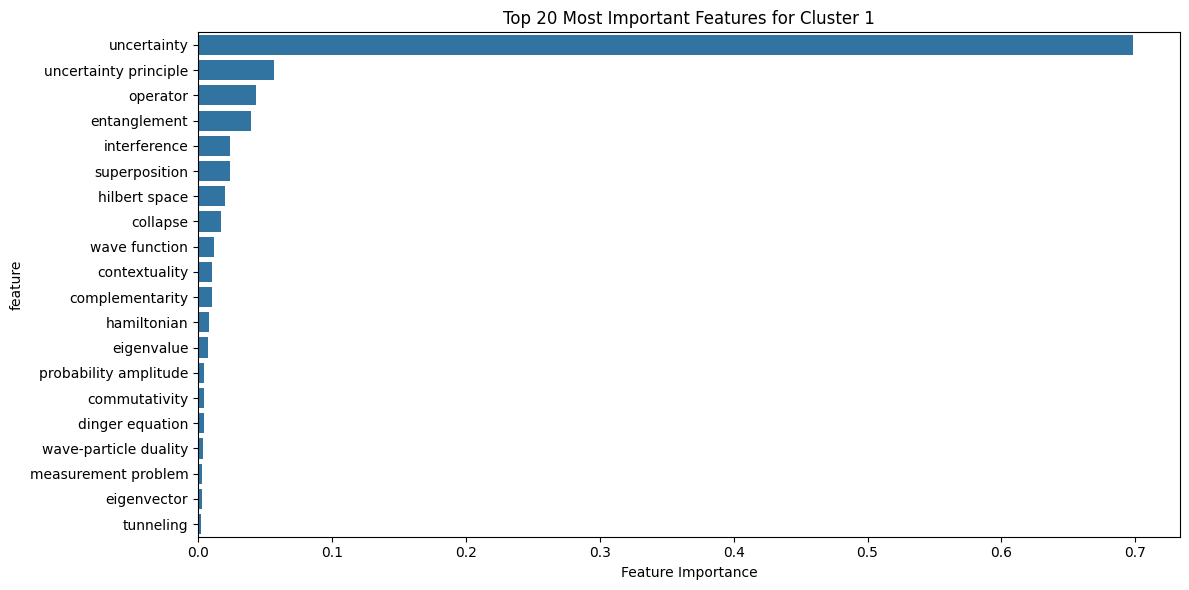


=== ANALYSIS FOR CLUSTER 2 ===

Top 10 most important features for Cluster 2:
          feature  importance
14       operator    0.641887
7    entanglement    0.052947
5      eigenvalue    0.043396
9     hamiltonian    0.034907
19    uncertainty    0.029523
11   interference    0.029242
17  superposition    0.027454
1        collapse    0.027140
10  hilbert space    0.026348
21  wave function    0.015121

Classification Report for Cluster 2:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       196
           1       1.00      0.94      0.97        36

    accuracy                           0.99       232
   macro avg       0.99      0.97      0.98       232
weighted avg       0.99      0.99      0.99       232



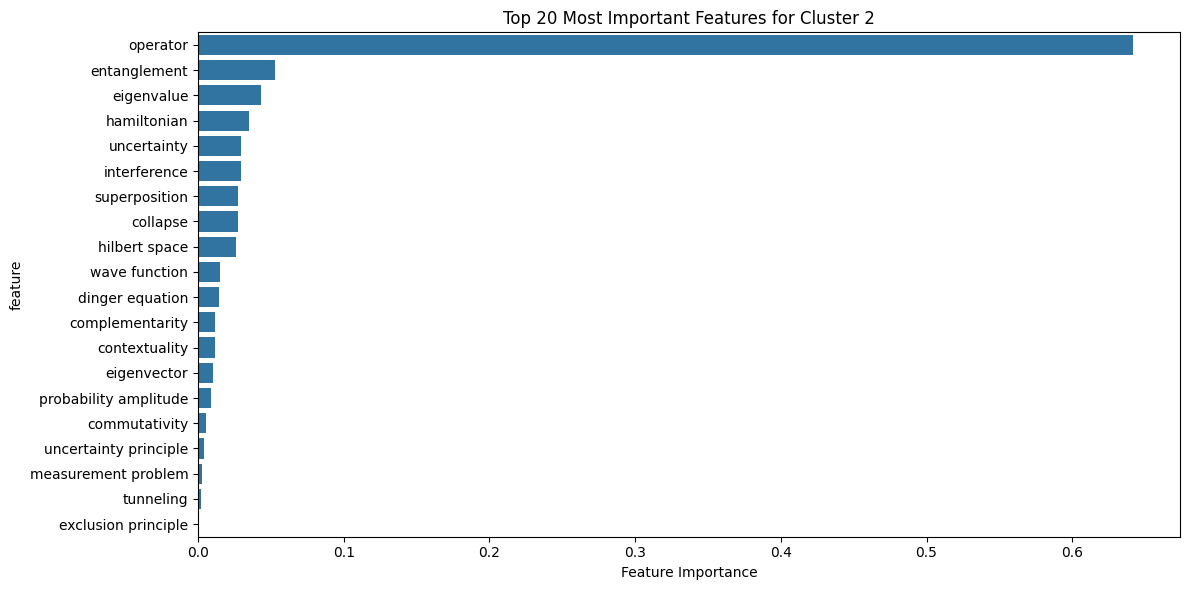


=== ANALYSIS FOR CLUSTER 3 ===

Top 10 most important features for Cluster 3:
          feature  importance
7    entanglement    0.713962
14       operator    0.051524
11   interference    0.039530
19    uncertainty    0.031716
10  hilbert space    0.023987
17  superposition    0.019545
1        collapse    0.018783
9     hamiltonian    0.015970
21  wave function    0.014145
4   contextuality    0.013427

Classification Report for Cluster 3:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       192
           1       0.95      0.95      0.95        40

    accuracy                           0.98       232
   macro avg       0.97      0.97      0.97       232
weighted avg       0.98      0.98      0.98       232



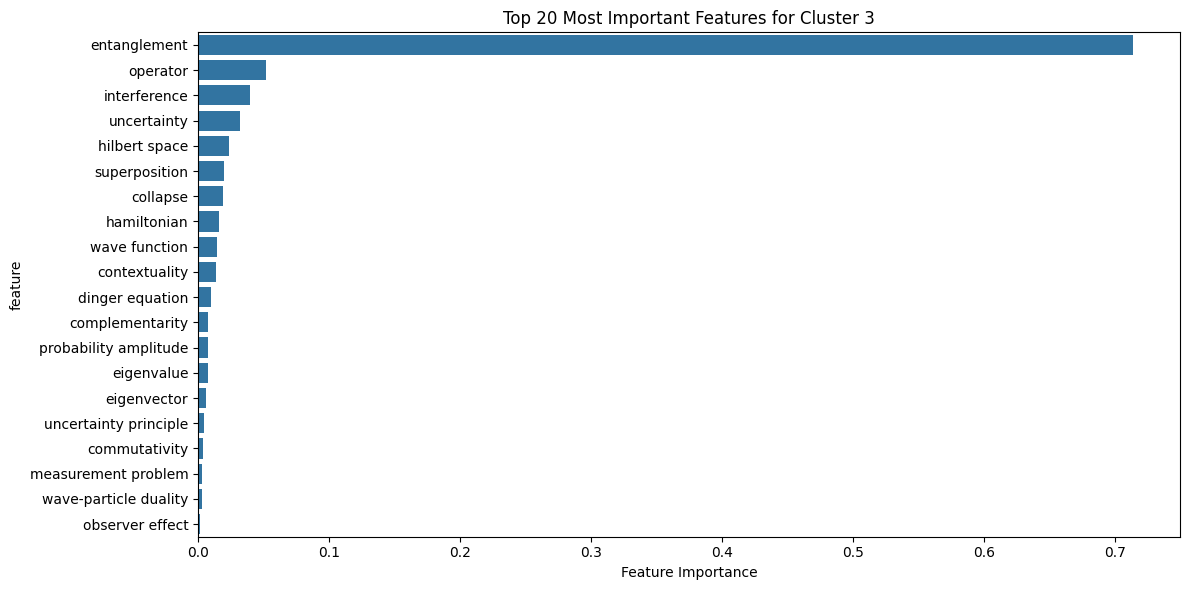


=== ANALYSIS FOR CLUSTER 4 ===

Top 10 most important features for Cluster 4:
          feature  importance
14       operator    0.254790
7    entanglement    0.232191
19    uncertainty    0.149616
11   interference    0.070314
17  superposition    0.057560
10  hilbert space    0.043960
1        collapse    0.038787
21  wave function    0.026483
4   contextuality    0.024231
9     hamiltonian    0.018246

Classification Report for Cluster 4:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        99
           1       0.96      0.98      0.97       133

    accuracy                           0.96       232
   macro avg       0.96      0.96      0.96       232
weighted avg       0.96      0.96      0.96       232



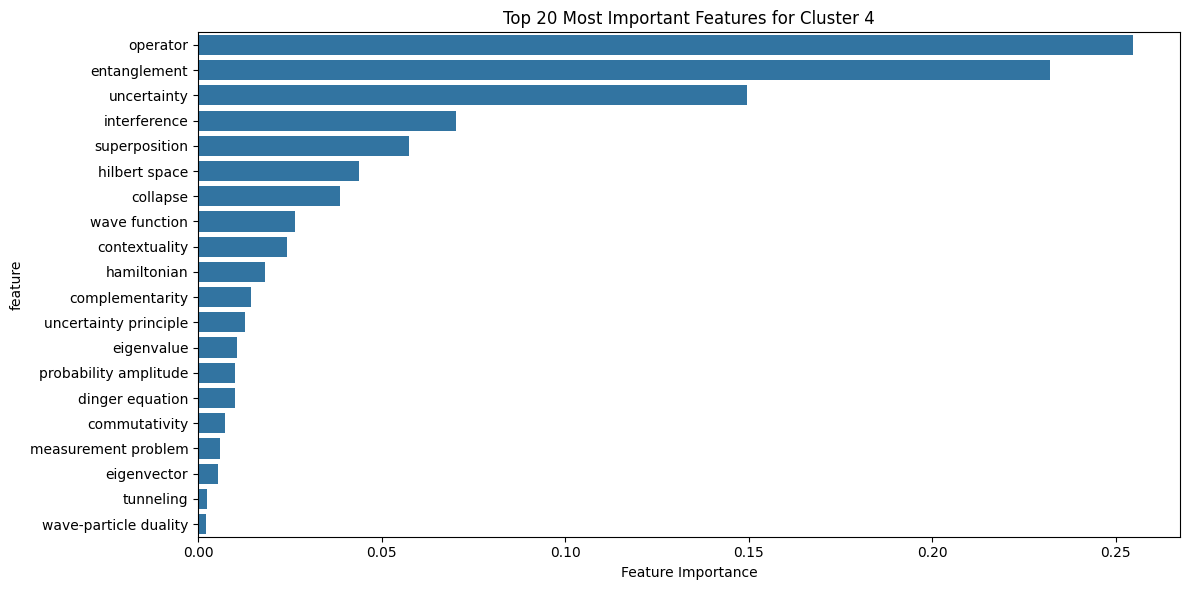

In [31]:
for cluster_num in range(1, 5):
    print(f"\n=== ANALYSIS FOR CLUSTER {cluster_num} ===")

    binary_labels = (final_labels + 1 == cluster_num).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        features, binary_labels, test_size=0.2, random_state=42
    )
    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf.fit(X_train, y_train)


    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': rf.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    ################################################

    # top 10 features for this cluster
    print(f"\nTop 10 most important features for Cluster {cluster_num}:")
    print(feature_importance.head(10))

    # Model performance
    y_pred = rf.predict(X_test)
    print(f"\nClassification Report for Cluster {cluster_num}:")
    print(classification_report(y_test, y_pred))

    # viz
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Most Important Features for Cluster {cluster_num}')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()